In [1]:
import torch
import matplotlib.pyplot as plt
from dataset import TextDataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from model import WordSubstitutionDetector
from model_trainer import ModelTrainer
from utils import create_embedding_matrix
from transformers import BertForTokenClassification, AdamW
from bert_for_token_classification_weighted import BertForTokenClassificationWeighted

%load_ext autoreload
%autoreload 2

In [2]:
data_dir = './data'
weights_dir = './weights'
device = 'cuda'

In [3]:
train_dataset = TextDataset(base_path=data_dir,
                            split_name='dev',
                            max_len=200)

train_sampler = RandomSampler(train_dataset)

train_loader = DataLoader(train_dataset,
                          batch_size=12,
                          sampler=train_sampler,
                          num_workers=6)


val_dataset = TextDataset(base_path=data_dir,
                          split_name='dev',
                          max_len=200)

val_sampler = SequentialSampler(val_dataset)

val_loader = DataLoader(val_dataset,
                        batch_size=12,
                        sampler=val_sampler,
                        num_workers=6)

[DATASET] Maximum line length: 200
[DATASET] Maximum line length: 200


In [4]:
len(train_loader)

625

In [5]:
for batch in train_loader:
    batch_lines, batch_labels, batch_masks = batch
    print(batch_lines[10])
    print(batch_labels[10])
    print(batch_masks[10])
    break

tensor([ 1996,  2137,  2914,  1997, 23614,  2015, 23126,  2350,  1037,  2004,
         1996,  3284,  1037,  2635,  2005,  2402,  4268,  1012,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

In [6]:
# word2id = train_dataset.word2id
# # pretrained_embeddings = create_embedding_matrix('../glove.6B/glove.6B.100d.txt', word2id, len(word2id), 100)


# model = WordSubstitutionDetector(len(word2id),
#                                  embedding_dim=100,
#                                  hidden_dim=200,
#                                  pretrained_embeddings=None).to(device)

# num_trainable_param = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print('{} trainable parameters'.format(num_trainable_param))

786801 trainable parameters


In [ ]:
# model.load_state_dict(torch.load('./weights/subst_detector_0019_0.0730.pt'))

In [4]:
model = BertForTokenClassificationWeighted.from_pretrained(
    "bert-base-uncased",
    # 2 labels -> logits: (32, 200, 2)
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
).to(device)

num_trainable_param = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('{} trainable parameters'.format(num_trainable_param))

109483778 trainable parameters


In [5]:
FULL_FINETUNING = True

if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {
            'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
            'weight_decay_rate': 0.01
        },
        {
            'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
            'weight_decay_rate': 0.0
        }
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

In [6]:
# criterion = torch.nn.BCEWithLogitsLoss()
# # optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-5)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9)

In [6]:
trainer = ModelTrainer(model, None, optimizer, device)

In [ ]:
train_loss, val_loss = trainer.fit(train_loader, val_loader, 0, 1)

Epoch 0/0


/home/apelykh/.virtualenvs/pytorch-nlp/lib/python3.8/site-packages/transformers/optimization.py:155: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)


[30/ 834] loss: 0.494
[60/ 834] loss: 0.268
[90/ 834] loss: 0.384


In [11]:
train_loss2, val_loss2 = trainer.fit(train_loader, val_loader, 10, 20)

Epoch 10/29
Epoch 10 train loss: 0.0376
Epoch 10 val loss: 0.0374
--------------------------------------------------
Epoch 11/29
Epoch 11 train loss: 0.0373
Epoch 11 val loss: 0.0372
--------------------------------------------------
Epoch 12/29
Epoch 12 train loss: 0.0371
Epoch 12 val loss: 0.0369
--------------------------------------------------
Epoch 13/29
Epoch 13 train loss: 0.0368
Epoch 13 val loss: 0.0367
--------------------------------------------------
Epoch 14/29
Epoch 14 train loss: 0.0365
Epoch 14 val loss: 0.0364
--------------------------------------------------
Epoch 15/29
Epoch 15 train loss: 0.0363
Epoch 15 val loss: 0.0362
--------------------------------------------------
Epoch 16/29
Epoch 16 train loss: 0.0360
Epoch 16 val loss: 0.0359
--------------------------------------------------
Epoch 17/29
Epoch 17 train loss: 0.0357
Epoch 17 val loss: 0.0356
--------------------------------------------------
Epoch 18/29
Epoch 18 train loss: 0.0355
Epoch 18 val loss: 0.035

In [11]:
train_loss3, val_loss3 = trainer.fit(train_loader, val_loader, 20, 10)

Epoch 20/29
[30/ 196] loss: 0.066
[60/ 196] loss: 0.064
[90/ 196] loss: 0.062
[120/ 196] loss: 0.061
[150/ 196] loss: 0.059
[180/ 196] loss: 0.058
Epoch 20 train loss: 0.0622
Epoch 20 val loss: 0.0677
--------------------------------------------------
Epoch 21/29
[30/ 196] loss: 0.056
[60/ 196] loss: 0.055
[90/ 196] loss: 0.053
[120/ 196] loss: 0.052
[150/ 196] loss: 0.051
[180/ 196] loss: 0.050
Epoch 21 train loss: 0.0530
Epoch 21 val loss: 0.0600
--------------------------------------------------
Epoch 22/29
[30/ 196] loss: 0.048
[60/ 196] loss: 0.047
[90/ 196] loss: 0.046
[120/ 196] loss: 0.045
[150/ 196] loss: 0.044
[180/ 196] loss: 0.043
Epoch 22 train loss: 0.0458
Epoch 22 val loss: 0.0539
--------------------------------------------------
Epoch 23/29
[30/ 196] loss: 0.042
[60/ 196] loss: 0.041
[90/ 196] loss: 0.040
[120/ 196] loss: 0.039
[150/ 196] loss: 0.039
[180/ 196] loss: 0.038
Epoch 23 train loss: 0.0400
Epoch 23 val loss: 0.0490
-------------------------------------------

In [12]:
train_loss.extend(train_loss2)
val_loss.extend(val_loss2)

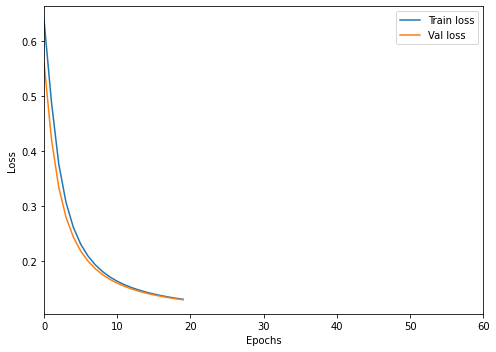

In [10]:
plt.figure(figsize=(7,5))
plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss');
plt.xlim(0, 60)
plt.legend()
plt.tight_layout()
plt.savefig('{}/loss.png'.format(weights_dir))

In [10]:
train_loss, val_loss = trainer.fit(train_loader, val_loader, 0, 30)

Epoch 0/29
[30/ 196] loss: 0.102
[60/ 196] loss: 0.096
[90/ 196] loss: 0.082
[120/ 196] loss: 0.074
[150/ 196] loss: 0.072
[180/ 196] loss: 0.076
Epoch 0 train loss: 0.1125
Epoch 0 val loss: 0.0723
--------------------------------------------------
Epoch 1/29
[30/ 196] loss: 0.070
[60/ 196] loss: 0.071
[90/ 196] loss: 0.069
[120/ 196] loss: 0.070
[150/ 196] loss: 0.069
[180/ 196] loss: 0.074
Epoch 1 train loss: 0.0709
Epoch 1 val loss: 0.0704
--------------------------------------------------
Epoch 2/29
[30/ 196] loss: 0.068
[60/ 196] loss: 0.069
[90/ 196] loss: 0.068
[120/ 196] loss: 0.068
[150/ 196] loss: 0.067
[180/ 196] loss: 0.072
Epoch 2 train loss: 0.0694
Epoch 2 val loss: 0.0693
--------------------------------------------------
Epoch 3/29
[30/ 196] loss: 0.067
[60/ 196] loss: 0.068
[90/ 196] loss: 0.067
[120/ 196] loss: 0.067
[150/ 196] loss: 0.066
[180/ 196] loss: 0.071
Epoch 3 train loss: 0.0684
Epoch 3 val loss: 0.0685
--------------------------------------------------
Epoc

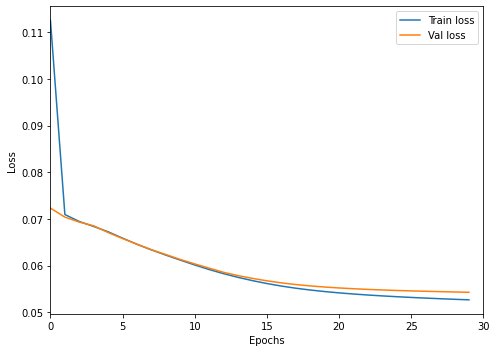

In [15]:
plt.figure(figsize=(7,5))
plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss');
plt.xlim(0, 30)
plt.legend()
plt.tight_layout()
plt.savefig('{}/loss.png'.format(weights_dir))